In [1]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation

import concurrent.futures
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np

In [2]:
# constants

batchSize = 64
noiseDim = 200
includedSimulations=23



In [5]:
# generates preprocessed datasets for our models and saves them to disk
trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader = preprocessing.gen_loaders( 
    batchSize,
    includedSimulations
)

pickle.dump(trainSpikesLoader, open("../data/trainSpikesLoader.pickle", "wb"))
pickle.dump(valSpikesLoader, open("../data/valSpikesLoader.pickle", "wb"))
pickle.dump(testSpikesLoader, open("../data/testSpikesLoader.pickle", "wb"))
pickle.dump(trainBgLoader, open("../data/trainBgLoader.pickle", "wb"))
pickle.dump(valBgLoader, open("../data/valBgLoader.pickle", "wb"))
pickle.dump(testBgLoader, open("../data/testBgLoader.pickle", "wb"))

In [4]:
#loads preprocessed datasets from disk

trainSpikesLoader = pickle.load(open("../data/trainSpikesLoader.pickle", "rb"))
valSpikesLoader = pickle.load(open("../data/valSpikesLoader.pickle", "rb"))
testSpikesLoader = pickle.load(open("../data/testSpikesLoader.pickle", "rb"))
trainBgLoader = pickle.load(open("../data/trainBgLoader.pickle", "rb"))
valBgLoader = pickle.load(open("../data/valBgLoader.pickle", "rb"))
testBgLoader = pickle.load(open("../data/testBgLoader.pickle", "rb"))

Spike generator training


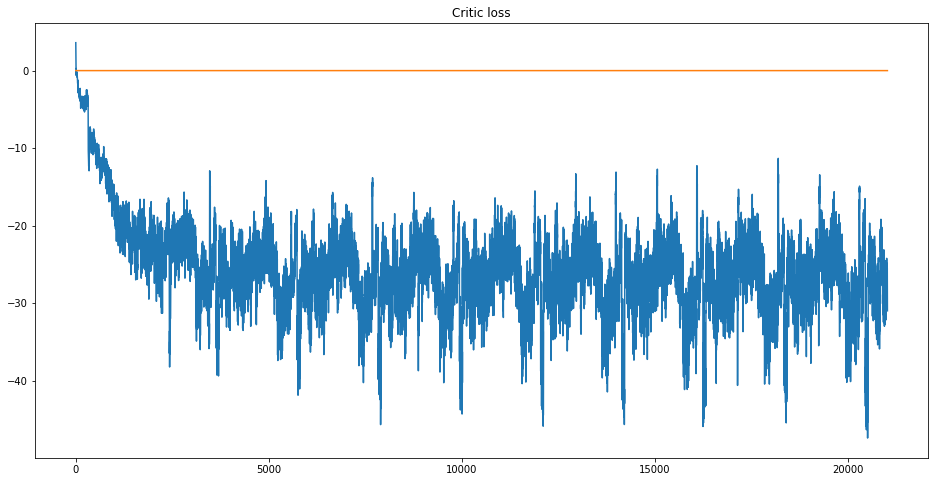

Critic loss -31.00433349609375

Epoch 9

Generated example:


IndexError: dimension specified as 0 but tensor has no dimensions

In [4]:
# declares and trains the gan for spikes 

gen1 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
critic1 = gans.CriticWgan(inputSize=80, hiddenSize=40)

print("Spike generator training")

gans.wgan_adversarial_trainer( 
    train_loader = trainSpikesLoader,
    generator = gen1, 
    critic = critic1, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 10,
)

In [11]:
#saving the spike models on disk 
PATHgen1="../data/models/gen1.pth"
PATHcritic1="../data/models/critic1.pth"
torch.save(gen1.state_dict(),PATH)
torch.save(critic1.state_dict(),PATHcritic1)

In [6]:
#loading the spike models from disk 
PATHgen1="../data/models/gen1.pth"
PATHcritic1="../data/models/critic1.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loadedGen1 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
loadedCritic1 = gans.CriticWgan(inputSize=80, hiddenSize=40)
#load the generator 
loadedGen1.load_state_dict(torch.load(PATHgen1))
loadedGen1.to(device)
#load the critic
loadedCritic1.load_state_dict(torch.load(PATHcritic1))
loadedCritic1.to(device)


_netC_wgan(
  (mainModule): Sequential(
    (0): Linear(in_features=80, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=1, bias=True)
  )
)

Background generator training


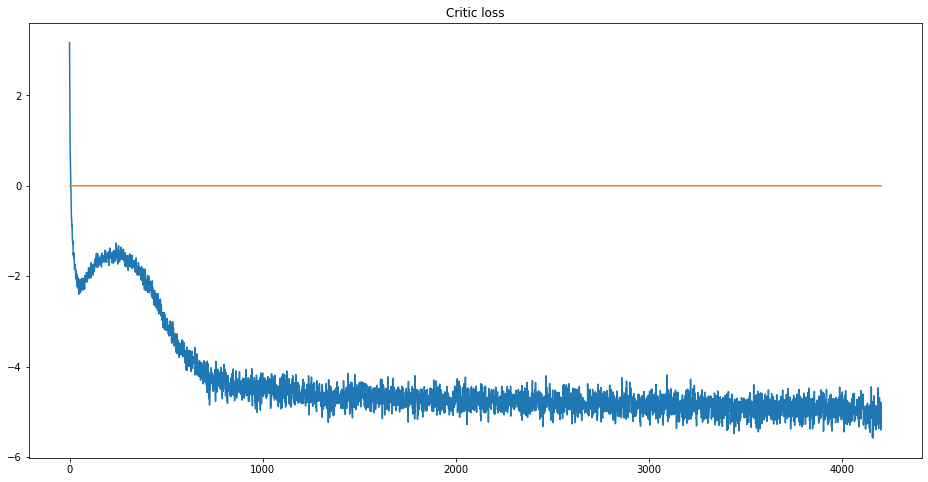

Critic loss -4.96935510635376

Epoch 1

Generated example:


IndexError: dimension specified as 0 but tensor has no dimensions

In [16]:
# declares and trains the gan for hash

gen2 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=10, outputSize=80)
critic2 = gans.CriticWgan(inputSize=80, hiddenSize=40)
print("Background generator training")

gans.wgan_adversarial_trainer( 
    train_loader = trainBgLoader,
    generator = gen2, 
    critic = critic2, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 2,
)

In [37]:
#save models for hash 
PATHgen2="../data/models/gen2.pth"
PATHcritic2="../data/models/critic2.pth"
torch.save(gen2.state_dict(),PATHgen2)
torch.save(critic2.state_dict(),PATHcritic2)

In [7]:
#loading the hash models from disk 
PATHgen2="../data/models/gen2.pth"
PATHcritic2="../data/models/critic2.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loadedGen2 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=10, outputSize=80)
loadedCritic2 = gans.CriticWgan(inputSize=80, hiddenSize=40)
#load generator for hash 
loadedGen2.load_state_dict(torch.load(PATHgen2))
loadedGen2.to(device)
#load critic for hash 
loadedCritic2.load_state_dict(torch.load(PATHcritic2))
loadedCritic2.to(device)

_netC_wgan(
  (mainModule): Sequential(
    (0): Linear(in_features=80, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=1, bias=True)
  )
)

torch.Size([16810, 80])


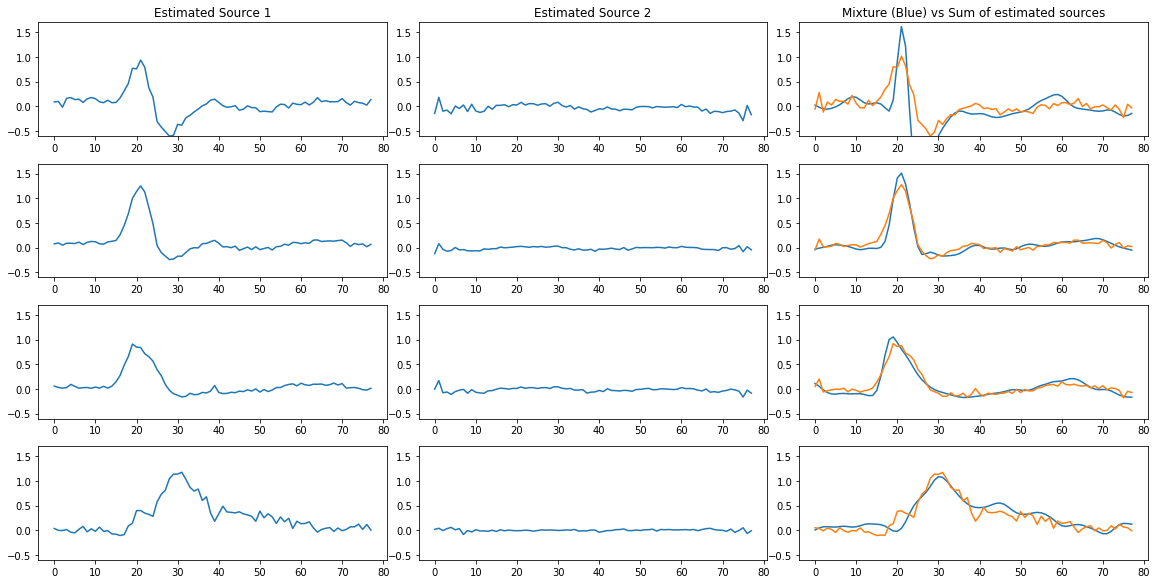

In [9]:
# separates the spike samples

(cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes) = sourceSeparation.maxlikelihood_separatesources(
    generators=[loadedGen1, loadedGen2],
    loader_mix=valSpikesLoader,
    epochs=3000
)

torch.Size([16810, 80])


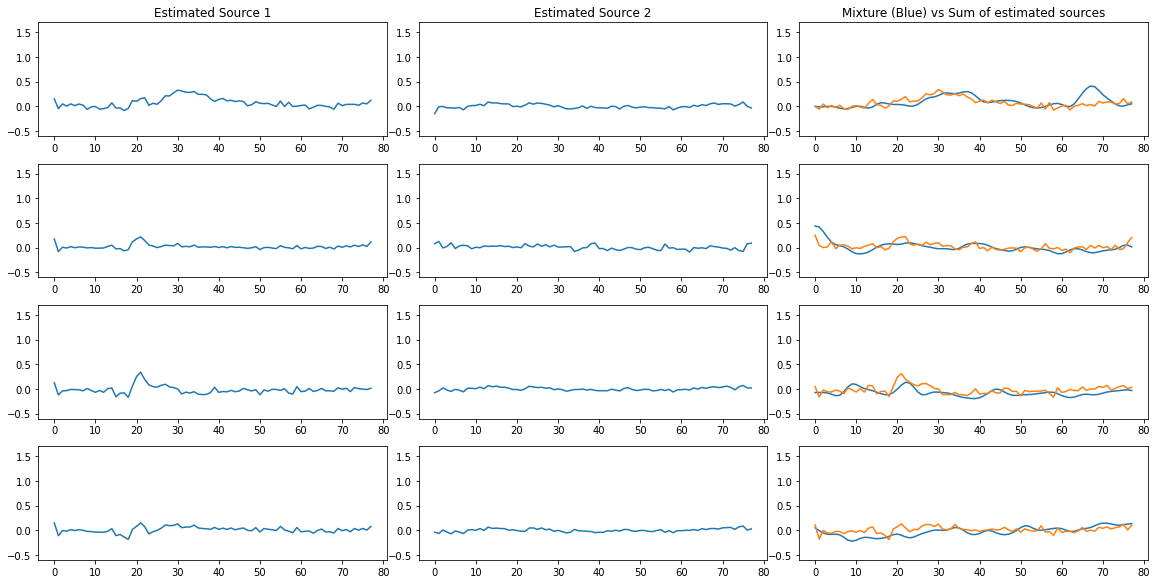

In [10]:
# separates the noise samples

(cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=valBgLoader,
    epochs=3000
)

In [11]:
valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)

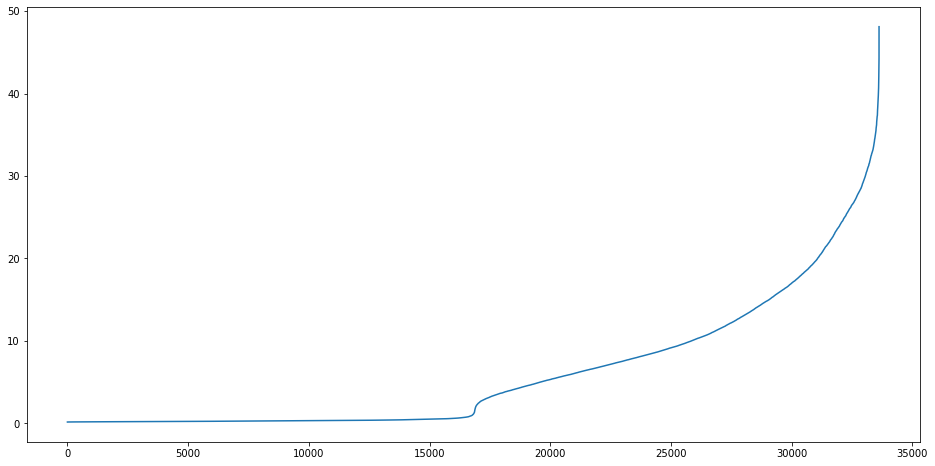

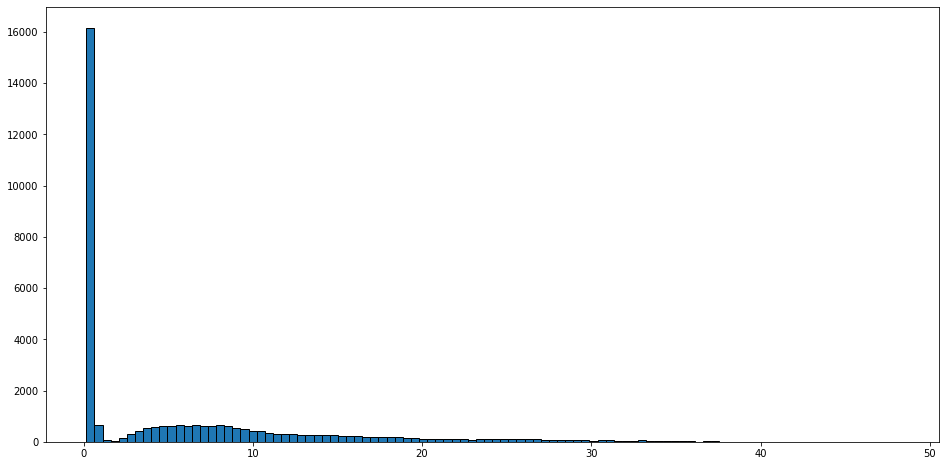

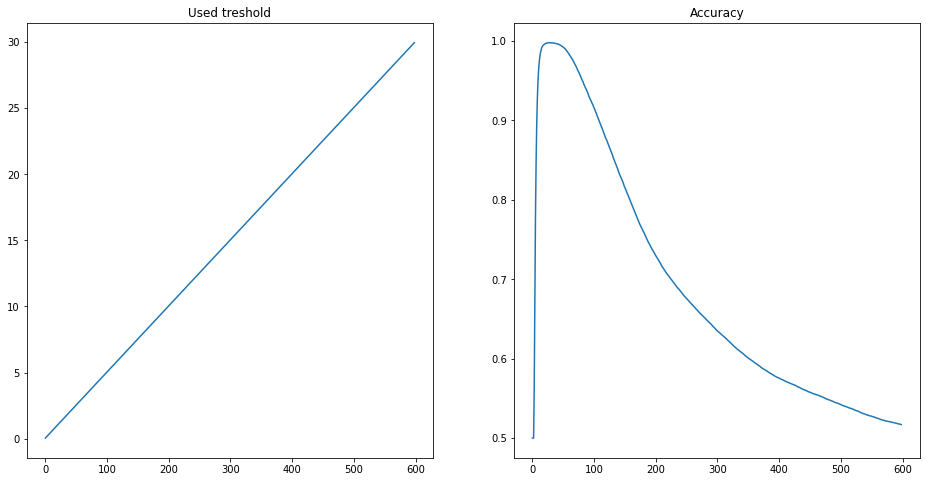

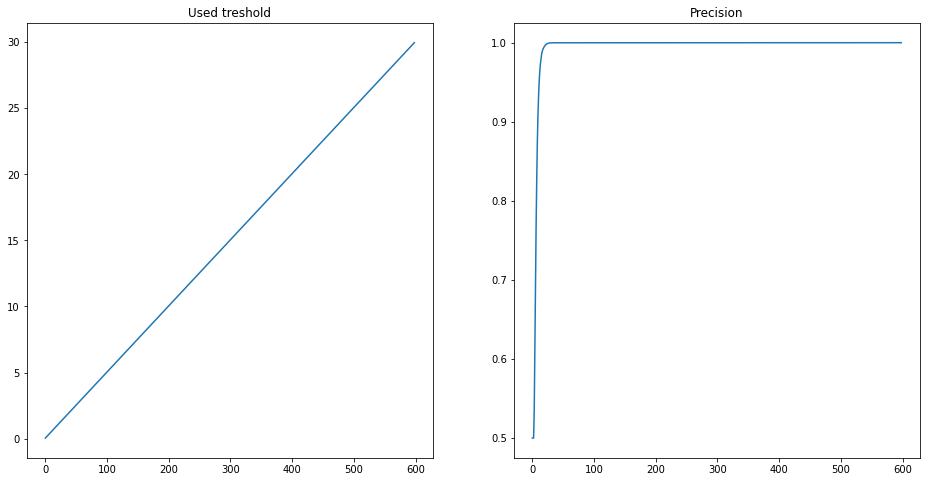

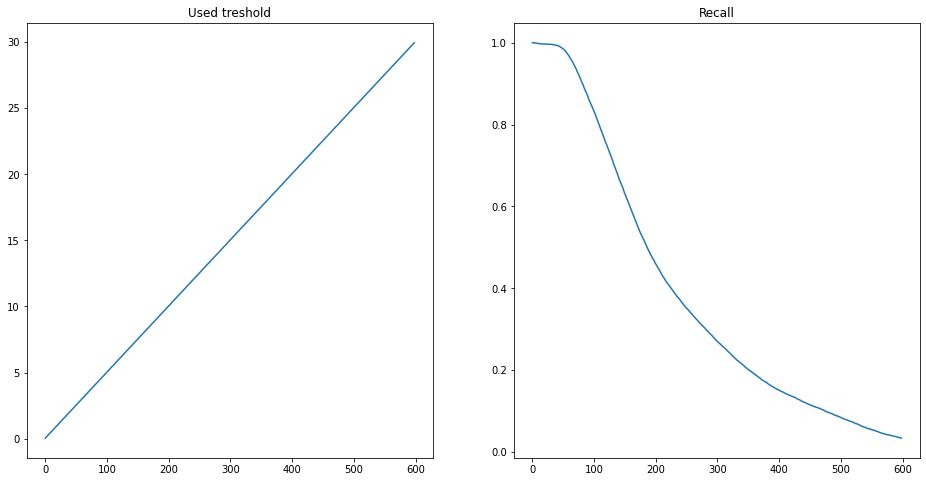

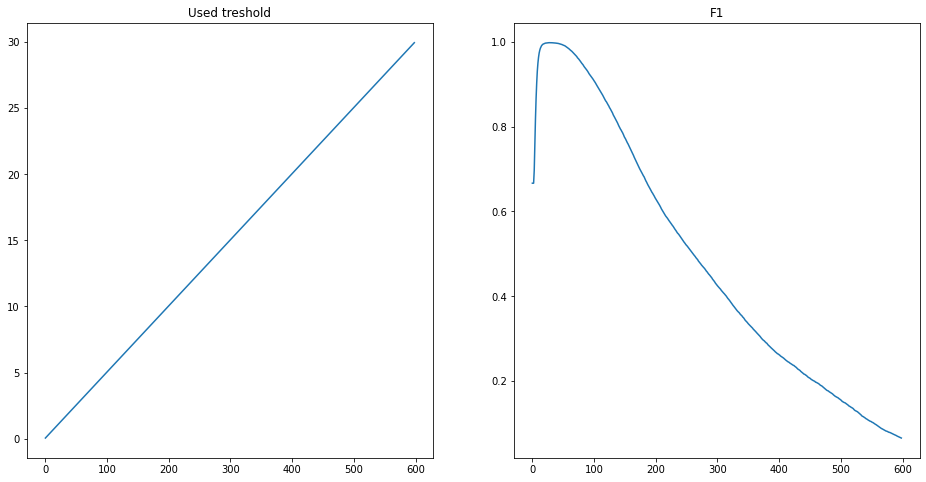

Threshold for best F1: 1.4
Threshold: 1.4
Precision: 0.9995822391978992
Recall: 0.9963712076145151
F1: 0.9979741404993149
Accuracy: 0.9979773944080904


In [12]:
sourceSeparation.interpretSeparation(valExtractedSpikes, critic1, vallabel)

torch.Size([10901, 80])


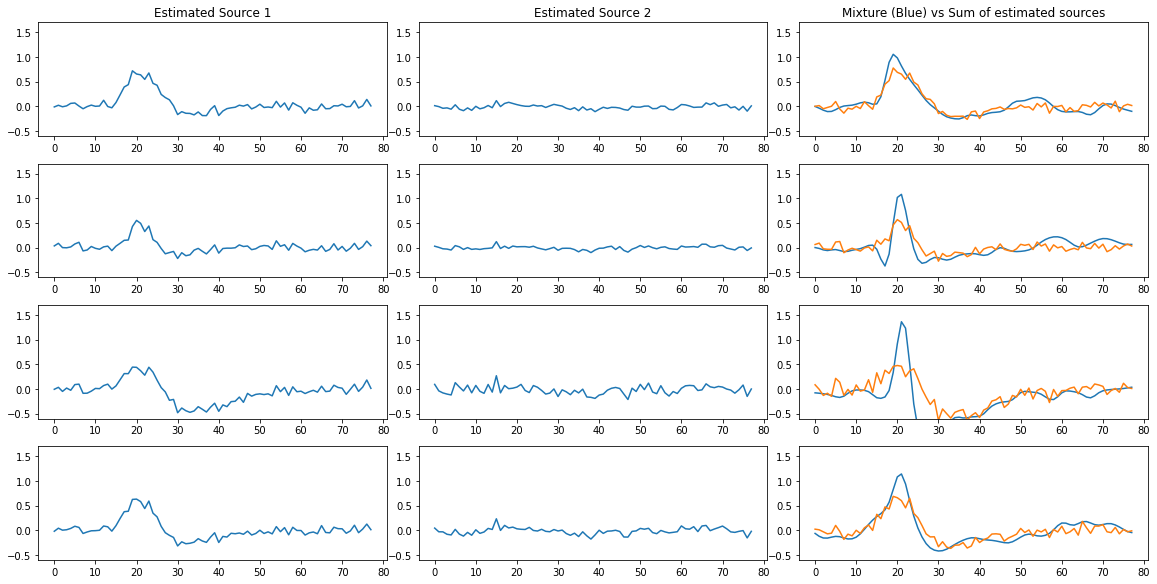

In [20]:
# separates the spike samples

(cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=testSpikesLoader,
    epochs=2000
)

torch.Size([10901, 80])


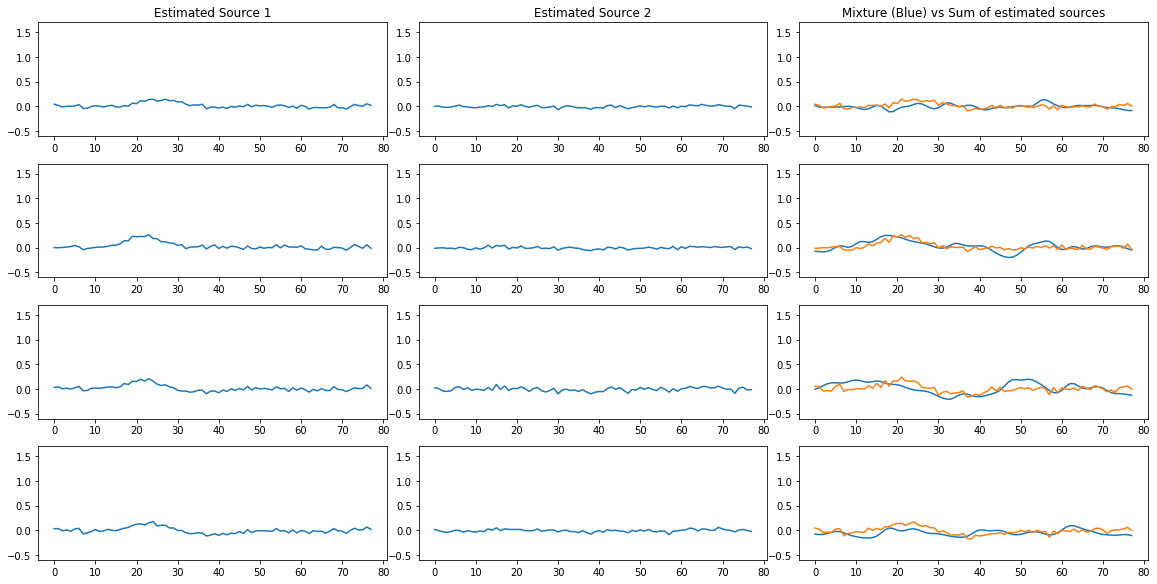

In [21]:
# separates the noise samples

(cleanextractedSpikesTestBg,cleanextractedNoisesTestBg) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=testBgLoader,
    epochs=2000
)

In [22]:
testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)

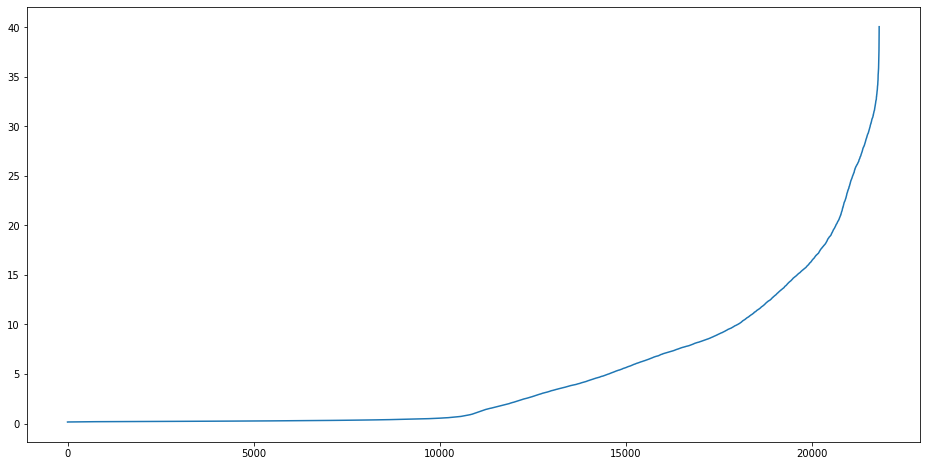

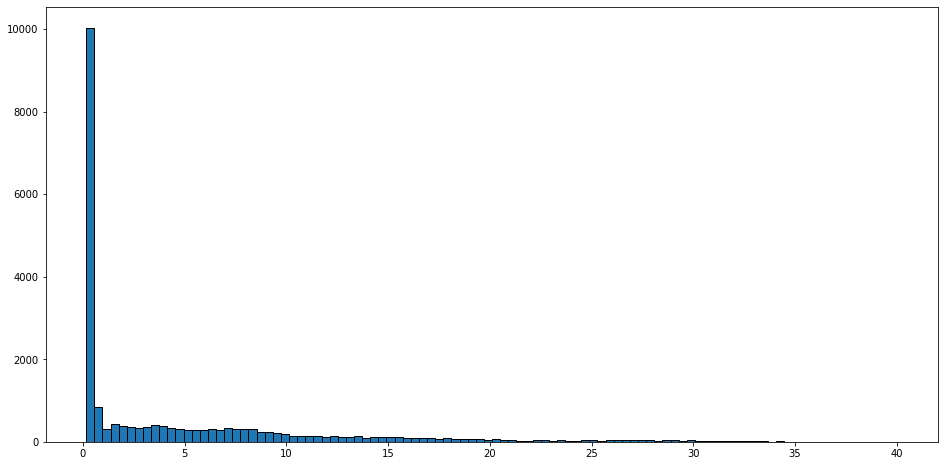

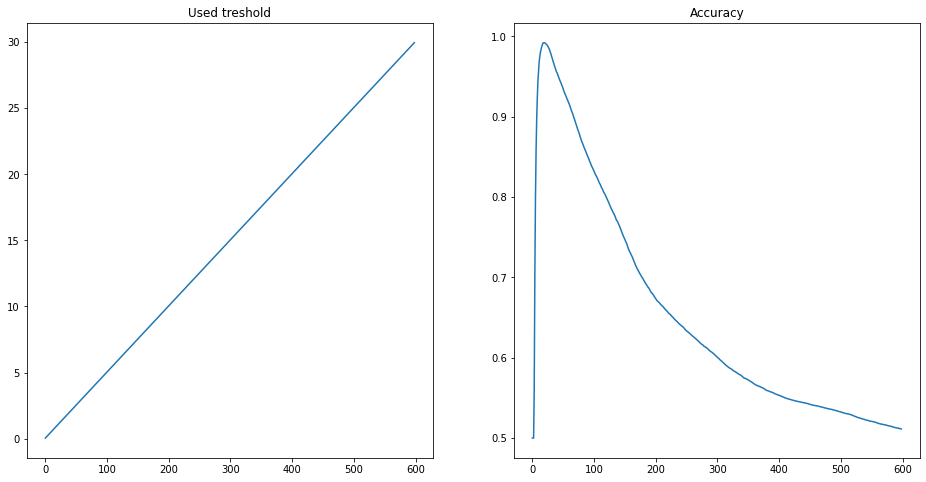

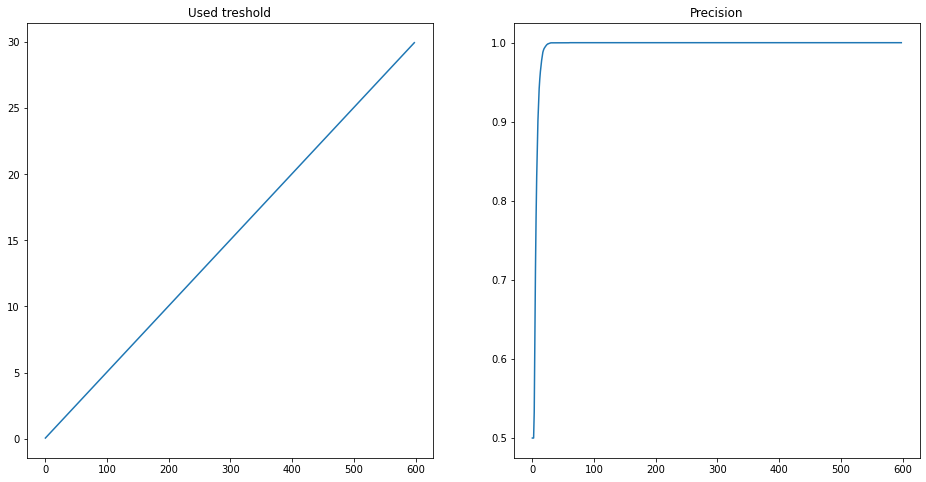

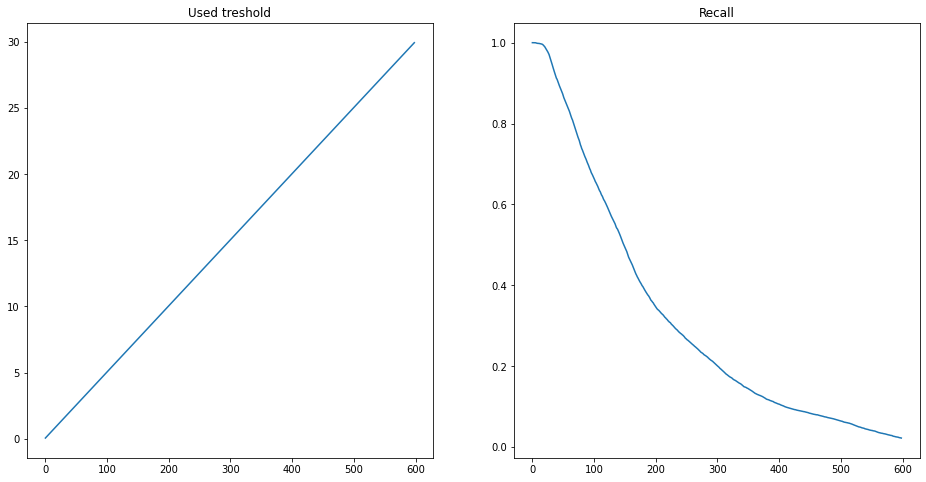

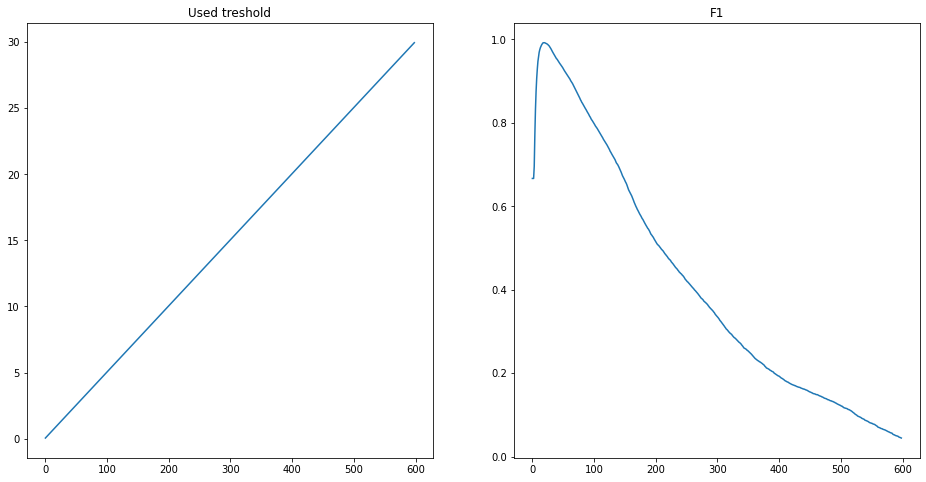

Threshold for best F1: 1.0
Threshold: 1.3
Precision: 0.9985003280532384
Recall: 0.9772497935969177
F1: 0.9877607788595272
Accuracy: 0.987891019172553


In [23]:
sourceSeparation.interpretSeparation(testExtractedSpikes, critic1, testlabel,test=True, testThreshold=1.3)